In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import arc as arc

import numpy as np
import scipy.constants as consts
from scipy.stats import maxwell
import os, sys
from functools import partialmethod

from my_classes import HiddenPrints, LaserCooling, Simulation

In [2]:
my_cooling = LaserCooling(initial_temperature=0.001,nr_particles=2000,I_of_I_sat=1/100, dB_dx=0)

units_of_gamma = -0.5
delta          = units_of_gamma* my_cooling.gamma
omega          = my_cooling.omega_0 + delta


In [3]:
my_sim = Simulation(MyLaserCooling = my_cooling, stepsize = 0.00005, tmax = 0.02, with_emission=True)
my_sim.simulate_one_detuning(omega=omega)

---------- Simulating cooling process ----------


100%|██████████| 2000/2000 [00:57<00:00, 34.80it/s]


---------- Calculating energies and temperatures ----------


100%|██████████| 401/401 [00:12<00:00, 32.08it/s]


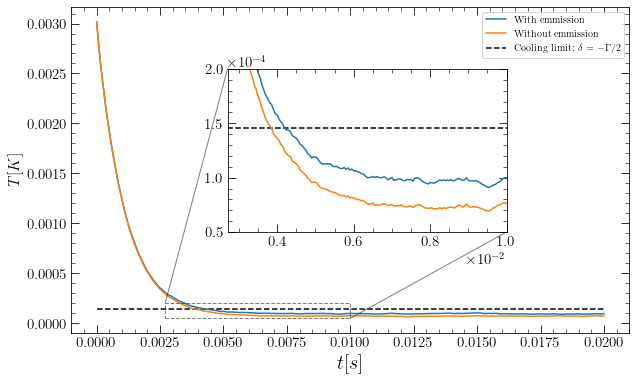

In [15]:
plt.rc('text', usetex=True)
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("xtick", labelsize = 15, top   = True, direction = "in")
plt.rc("ytick", labelsize = 15, right = True, direction = "in")
fig, ax = plt.subplots(figsize=(10,6))

#------------ Main plot --------------#
ax.plot(my_sim.ts,my_sim.Temperature_with_emission,label="With emmission")
ax.plot(my_sim.ts,my_sim.Temperature_without_emission,label="Without emmission")

min_detuning = -0.5 * my_cooling.gamma
lim          = my_sim.temperature_dependency(min_detuning)

ax.hlines(lim,0,np.max(my_sim.ts),color="k",ls="--",label=r"Cooling limit: $\delta = -\Gamma/2$")
ax.set_xlabel(r'$t [s]$',fontsize=20)
ax.set_ylabel(r'$T [K]$',fontsize=16)

#------------ Zoom plot --------------#
zoom_ax = ax.inset_axes([0.28,0.31,0.5,0.5])
zoom_ax.ticklabel_format(style='sci',scilimits=(5,3))
zoom_ax.set_xlim(0.0027,0.01)
zoom_ax.set_ylim(0.00005,0.2e-3)

zoom_ax.plot(my_sim.ts,my_sim.Temperature_with_emission)
zoom_ax.plot(my_sim.ts,my_sim.Temperature_without_emission)
ax.indicate_inset_zoom(zoom_ax, edgecolor="black",linestyle="--")
zoom_ax.hlines(lim,0,np.max(my_sim.ts),colors='k',ls='--')

#------------ General ----------------#
#ax.set_title(r"(Using $\frac{dB}{dx}$ = "+f"{my_cooling.magnetic_gradient})",y=1.01,size=15)
#fig.suptitle(r"Comparison of with/without emission, for $\delta$ = "+f"{units_of_gamma}"+r"$\Gamma$",size=24)
ax.legend()
plt.subplots_adjust(wspace=0.1)
plt.savefig(fname="With vs. without emission - no magnetic field.jpg", dpi=500)
plt.show()

In [8]:
nr_detunings  = 50
detunings     = np.linspace(-2, -0.001, nr_detunings) * my_cooling.gamma 
omegas        = my_cooling.omega_0 + detunings

my_sim.simulate_multiple_detunings(omegas=omegas)

Temperatures_without_emission = my_sim.multiple_temperatures_without_emission   
Temperatures_with_emission    = my_sim.multiple_temperatures_with_emission   

  0%|          | 0/50 [00:00<?, ?it/s]

---------- Simulating laser cooling for 50 detunings ----------


100%|██████████| 50/50 [39:13<00:00, 47.08s/it]


---------- Calculating energies and corresponding temperatures----------


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


In [9]:
Temperatures_without_emission = my_sim.multiple_temperatures_without_emission   
Temperatures_with_emission    = my_sim.multiple_temperatures_with_emission   

In [37]:
def write_out(data, variable_names, file_name, header_comment = None):
    my_header = "#"*100+"\n"
    my_header += "Data formatted as: | "
    for name in variable_names:
        my_header += name
        my_header += " | "
    if header_comment is not None:
        my_header += "\n"+"-"*100
        my_header += "\n"+header_comment
    my_header += "\n"+"#"*100
    format_len = np.max([len(str(number)) for number in data.flatten()])
    my_formatter = '%-'+str(int(format_len*2))+'s'
    np.savetxt(fname=file_name, X=data, fmt=my_formatter, header=my_header)

In [38]:
my_variable_names = ["Temperature without emission", "Temperatures with emission","Detuning/Gamma"]
my_data           = np.stack([Temperatures_without_emission, Temperatures_with_emission, detunings / my_cooling.gamma],axis=1)
my_comment        = "Settings: temperature=0.0001, nr_particles=20000, I_of_I_sat=1/100, stepsize = 0.0005, tmax = 0.02"
my_filename       = "multiple_detunings_sim.txt" 
write_out(data=my_data,variable_names=my_variable_names,file_name=my_filename,header_comment=my_comment)


In [196]:
my_data = np.loadtxt("multiple_detunings_sim.txt", skiprows=5)

Temperatures_without_emission = my_data[:,0]
Temperatures_with_emission    = my_data[:,1]
xs                            = my_data[:,2]
ys                            = my_sim.temperature_dependency(xs * my_cooling.gamma)

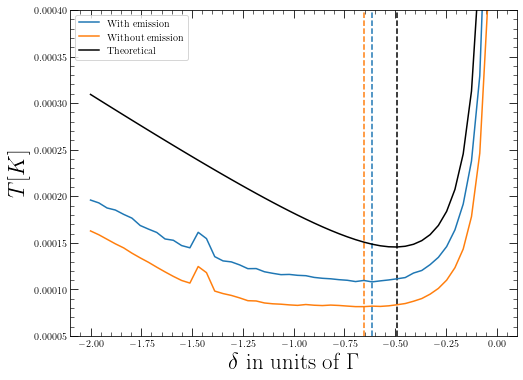

In [227]:
fig, ax = plt.subplots(figsize=(8,6))

#xs = detunings / my_cooling.gamma
#ys = my_sim.temperature_dependency(detunings)


#------------ Main plot --------------#
ax.plot(xs, Temperatures_with_emission, label    = "With emission", color="tab:blue")
ax.plot(xs, Temperatures_without_emission, label = "Without emission", color="tab:orange")
ax.plot(xs, ys, label = "Theoretical", color="k",ls="-")

ax.set_ylim(0.00005,0.0004)
ax.vlines(xs[np.argmin(Temperatures_with_emission)],0.00005,0.0004,ls="--", color="tab:blue")
ax.vlines(xs[np.argmin(Temperatures_without_emission)],0.00005,0.0004,ls="--", color="tab:orange")
ax.vlines(xs[np.argmin(ys)],0.00005,0.0004,ls="--", color="k")

ax.set_xlabel(r'$\delta$ in units of $\Gamma$',fontsize=23)
ax.set_ylabel(r'$T [K]$',fontsize=23)


"""
#------------ Zoom plot --------------#
zoom_ax = ax.inset_axes([0.285,0.6,0.35,0.35])
zoom_ax.ticklabel_format(style='sci',scilimits=(5,3))
zoom_ax.set_xlim(-0.75,-0.45)
zoom_ax.set_ylim(0.00005,0.2e-3)

zoom_ax.plot(xs,ys,color="tab:blue")
zoom_ax.plot(xs,Temperatures_without_emission,color="tab:green")
zoom_ax.plot(xs,Temperatures_with_emission,color="tab:orange")
ax.indicate_inset_zoom(zoom_ax, edgecolor="black",linestyle="--")
zoom_ax.hlines(lim,0,np.max(my_sim.ts),colors='k',ls='--')
"""

#------------ General --------------#
ax.legend()
plt.savefig(fname="temp vs. detuning - no magnetic field.jpg", dpi=500)

plt.show()